In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns

In [70]:
from datetime import datetime, timedelta

In [71]:
import statsmodels.api as sm
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.api import VAR

In [72]:
from sklearn import metrics

In [73]:
import sys
!conda install --yes --prefix {sys.prefix} -c saravji pmdarima
import pmdarima as pm

In [74]:
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv', sep=',')

In [75]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


Удаляем колонки согласно ТЗ:

In [76]:
df.drop(columns=['weather_description','weather_main','clouds_all','snow_1h','rain_1h'], axis=1, inplace=True)

In [77]:
df.head()

,holiday,temp,date_time,traffic_volume
0,None,288.28,2012-10-02 09:00:00,5545
1,None,289.36,2012-10-02 10:00:00,4516
2,None,289.58,2012-10-02 11:00:00,4767
3,None,290.13,2012-10-02 12:00:00,5026
4,None,291.14,2012-10-02 13:00:00,4918


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         48204 non-null  object 
 1   temp            48204 non-null  float64
 2   date_time       48204 non-null  object 
 3   traffic_volume  48204 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 1.5+ MB


In [79]:
df.shape

(48204, 4)

Убираем дубли, оставляя последнюю запись:

In [80]:
df.drop_duplicates(subset=['date_time'], keep='last', inplace=True)

In [81]:
df.shape

(40575, 4)

In [82]:
unique, counts = np.unique(df['date_time'], return_counts=True)
for key,value in dict(zip(unique, counts)).items():
    if value > 1:
        print(f'Количество записей даты: {key} - {value}')

Преобразуем колонку "date_time" в datetime, т.к. нужны вычисления по этим данным:

In [83]:
df['date_time'] =  pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')

In [84]:
df.isnull().sum()

holiday           0
temp              0
date_time         0
traffic_volume    0
dtype: int64

Пропусков в данных нет. Сбрасываем индекс, т.к. мы удаляли дубликаты и индекс поплыл:

In [85]:
df = df.reset_index(drop=True)

Проверим есть ли неравномерность в срезах каждый час:

In [86]:
for index, row in df.iterrows():
    if index > 0:
        if (df.loc[index, ('date_time')] - df.loc[index - 1, ('date_time')]).seconds > 3600:
            print(f"{df.loc[index - 1, ('date_time')]} - {df.loc[index, ('date_time')]}")

2012-10-03 06:00:00 - 2012-10-03 08:00:00
2012-10-03 09:00:00 - 2012-10-03 12:00:00
2012-10-03 16:00:00 - 2012-10-03 18:00:00
2012-10-05 01:00:00 - 2012-10-05 03:00:00
2012-10-05 03:00:00 - 2012-10-05 05:00:00
2012-10-06 02:00:00 - 2012-10-06 04:00:00
2012-10-07 00:00:00 - 2012-10-07 03:00:00
2012-10-09 02:00:00 - 2012-10-09 04:00:00
2012-10-10 03:00:00 - 2012-10-10 06:00:00
2012-10-10 16:00:00 - 2012-10-10 18:00:00
2012-10-10 23:00:00 - 2012-10-11 01:00:00
2012-10-11 01:00:00 - 2012-10-11 03:00:00
2012-10-11 10:00:00 - 2012-10-11 14:00:00
2012-10-12 18:00:00 - 2012-10-12 23:00:00
2012-10-21 00:00:00 - 2012-10-21 08:00:00
2012-10-21 08:00:00 - 2012-10-21 17:00:00
2012-10-21 18:00:00 - 2012-10-21 22:00:00
2012-10-22 06:00:00 - 2012-10-22 10:00:00
2012-10-25 08:00:00 - 2012-10-25 10:00:00
2012-11-04 03:00:00 - 2012-11-04 05:00:00
2012-11-05 14:00:00 - 2012-11-05 16:00:00
2012-11-05 18:00:00 - 2012-11-05 20:00:00
2012-11-06 10:00:00 - 2012-11-06 12:00:00
2012-11-11 21:00:00 - 2012-11-11 2

2013-06-13 04:00:00 - 2013-06-13 06:00:00
2013-06-13 19:00:00 - 2013-06-13 21:00:00
2013-06-19 03:00:00 - 2013-06-19 05:00:00
2013-06-19 06:00:00 - 2013-06-19 10:00:00
2013-06-19 11:00:00 - 2013-06-19 15:00:00
2013-06-19 16:00:00 - 2013-06-19 21:00:00
2013-06-19 21:00:00 - 2013-06-19 23:00:00
2013-06-19 23:00:00 - 2013-06-20 04:00:00
2013-06-20 05:00:00 - 2013-06-20 09:00:00
2013-06-20 13:00:00 - 2013-06-20 17:00:00
2013-06-20 18:00:00 - 2013-06-20 23:00:00
2013-06-21 03:00:00 - 2013-06-21 16:00:00
2013-06-21 16:00:00 - 2013-06-21 21:00:00
2013-06-22 00:00:00 - 2013-06-22 02:00:00
2013-06-22 09:00:00 - 2013-06-22 18:00:00
2013-06-22 19:00:00 - 2013-06-22 23:00:00
2013-06-23 02:00:00 - 2013-06-23 05:00:00
2013-06-23 09:00:00 - 2013-06-23 11:00:00
2013-06-23 12:00:00 - 2013-06-23 16:00:00
2013-06-23 17:00:00 - 2013-06-23 21:00:00
2013-06-24 00:00:00 - 2013-06-24 02:00:00
2013-06-27 11:00:00 - 2013-06-27 13:00:00
2013-06-28 11:00:00 - 2013-06-28 13:00:00
2013-06-29 20:00:00 - 2013-06-29 2

2013-11-16 05:00:00 - 2013-11-16 07:00:00
2013-11-16 07:00:00 - 2013-11-16 09:00:00
2013-11-16 09:00:00 - 2013-11-16 11:00:00
2013-11-16 11:00:00 - 2013-11-16 13:00:00
2013-11-17 10:00:00 - 2013-11-17 12:00:00
2013-11-17 19:00:00 - 2013-11-17 21:00:00
2013-11-18 05:00:00 - 2013-11-18 07:00:00
2013-11-18 13:00:00 - 2013-11-18 15:00:00
2013-11-18 15:00:00 - 2013-11-18 17:00:00
2013-11-25 06:00:00 - 2013-11-25 08:00:00
2013-11-25 08:00:00 - 2013-11-25 10:00:00
2013-11-25 12:00:00 - 2013-11-25 14:00:00
2013-11-26 00:00:00 - 2013-11-26 02:00:00
2013-11-26 15:00:00 - 2013-11-26 17:00:00
2013-11-26 21:00:00 - 2013-11-26 23:00:00
2013-11-28 04:00:00 - 2013-11-28 06:00:00
2013-11-29 07:00:00 - 2013-11-29 09:00:00
2013-12-03 21:00:00 - 2013-12-03 23:00:00
2013-12-05 17:00:00 - 2013-12-05 19:00:00
2013-12-05 22:00:00 - 2013-12-06 00:00:00
2013-12-06 09:00:00 - 2013-12-06 11:00:00
2013-12-07 10:00:00 - 2013-12-07 12:00:00
2013-12-07 15:00:00 - 2013-12-07 17:00:00
2013-12-08 02:00:00 - 2013-12-08 0

2015-07-12 10:00:00 - 2015-07-12 12:00:00
2015-07-29 16:00:00 - 2015-07-29 18:00:00
2015-07-30 19:00:00 - 2015-07-30 21:00:00
2015-08-05 17:00:00 - 2015-08-05 19:00:00
2015-08-10 01:00:00 - 2015-08-10 03:00:00
2015-08-17 09:00:00 - 2015-08-17 11:00:00
2015-08-22 05:00:00 - 2015-08-22 07:00:00
2015-08-25 22:00:00 - 2015-08-26 00:00:00
2015-08-29 16:00:00 - 2015-08-30 02:00:00
2015-09-01 01:00:00 - 2015-09-01 04:00:00
2015-09-01 04:00:00 - 2015-09-01 10:00:00
2015-09-01 16:00:00 - 2015-09-02 02:00:00
2015-09-02 03:00:00 - 2015-09-02 06:00:00
2015-09-14 00:00:00 - 2015-09-14 02:00:00
2015-09-16 06:00:00 - 2015-09-16 11:00:00
2015-09-20 18:00:00 - 2015-09-20 20:00:00
2015-09-20 20:00:00 - 2015-09-20 22:00:00
2015-09-20 22:00:00 - 2015-09-21 00:00:00
2015-09-21 00:00:00 - 2015-09-21 02:00:00
2015-09-21 06:00:00 - 2015-09-21 08:00:00
2015-09-21 10:00:00 - 2015-09-21 12:00:00
2015-09-22 06:00:00 - 2015-09-22 11:00:00
2015-09-22 18:00:00 - 2015-09-22 20:00:00
2015-09-23 14:00:00 - 2015-09-23 1

2015-12-20 02:00:00 - 2015-12-20 04:00:00
2015-12-20 07:00:00 - 2015-12-20 09:00:00
2015-12-20 12:00:00 - 2015-12-20 14:00:00
2015-12-20 14:00:00 - 2015-12-20 16:00:00
2015-12-20 16:00:00 - 2015-12-20 18:00:00
2015-12-20 18:00:00 - 2015-12-20 20:00:00
2015-12-20 20:00:00 - 2015-12-20 22:00:00
2015-12-20 23:00:00 - 2015-12-21 01:00:00
2015-12-21 02:00:00 - 2015-12-21 05:00:00
2015-12-21 05:00:00 - 2015-12-21 07:00:00
2015-12-21 07:00:00 - 2015-12-21 09:00:00
2015-12-21 09:00:00 - 2015-12-21 11:00:00
2015-12-21 12:00:00 - 2015-12-21 14:00:00
2015-12-21 14:00:00 - 2015-12-21 16:00:00
2015-12-21 16:00:00 - 2015-12-21 18:00:00
2015-12-21 18:00:00 - 2015-12-21 20:00:00
2015-12-21 20:00:00 - 2015-12-21 22:00:00
2015-12-21 23:00:00 - 2015-12-22 01:00:00
2015-12-22 01:00:00 - 2015-12-22 04:00:00
2015-12-22 04:00:00 - 2015-12-22 06:00:00
2015-12-22 06:00:00 - 2015-12-22 08:00:00
2015-12-22 08:00:00 - 2015-12-22 10:00:00
2015-12-22 10:00:00 - 2015-12-22 12:00:00
2015-12-22 12:00:00 - 2015-12-22 1

2016-01-23 12:00:00 - 2016-01-23 14:00:00
2016-01-23 14:00:00 - 2016-01-23 16:00:00
2016-01-23 16:00:00 - 2016-01-23 18:00:00
2016-01-23 18:00:00 - 2016-01-23 20:00:00
2016-01-23 20:00:00 - 2016-01-23 22:00:00
2016-01-24 03:00:00 - 2016-01-24 05:00:00
2016-01-24 06:00:00 - 2016-01-24 08:00:00
2016-01-24 08:00:00 - 2016-01-24 10:00:00
2016-01-24 11:00:00 - 2016-01-24 13:00:00
2016-01-24 13:00:00 - 2016-01-24 15:00:00
2016-01-24 15:00:00 - 2016-01-24 17:00:00
2016-01-24 17:00:00 - 2016-01-24 19:00:00
2016-01-24 19:00:00 - 2016-01-24 21:00:00
2016-01-24 21:00:00 - 2016-01-24 23:00:00
2016-01-25 00:00:00 - 2016-01-25 02:00:00
2016-01-25 03:00:00 - 2016-01-25 06:00:00
2016-01-25 07:00:00 - 2016-01-25 09:00:00
2016-01-25 10:00:00 - 2016-01-25 12:00:00
2016-01-25 12:00:00 - 2016-01-25 14:00:00
2016-01-25 14:00:00 - 2016-01-25 16:00:00
2016-01-25 16:00:00 - 2016-01-25 18:00:00
2016-01-25 18:00:00 - 2016-01-25 20:00:00
2016-01-25 20:00:00 - 2016-01-25 22:00:00
2016-01-25 23:00:00 - 2016-01-26 0

2016-03-13 01:00:00 - 2016-03-13 04:00:00
2016-03-13 05:00:00 - 2016-03-13 07:00:00
2016-03-13 13:00:00 - 2016-03-13 15:00:00
2016-03-13 15:00:00 - 2016-03-13 17:00:00
2016-03-13 17:00:00 - 2016-03-13 19:00:00
2016-03-13 19:00:00 - 2016-03-13 21:00:00
2016-03-13 22:00:00 - 2016-03-14 00:00:00
2016-03-14 00:00:00 - 2016-03-14 02:00:00
2016-03-14 02:00:00 - 2016-03-14 04:00:00
2016-03-14 05:00:00 - 2016-03-14 08:00:00
2016-03-14 10:00:00 - 2016-03-14 12:00:00
2016-03-14 13:00:00 - 2016-03-14 15:00:00
2016-03-14 15:00:00 - 2016-03-14 17:00:00
2016-03-14 17:00:00 - 2016-03-14 19:00:00
2016-03-14 19:00:00 - 2016-03-14 21:00:00
2016-03-14 21:00:00 - 2016-03-14 23:00:00
2016-03-15 01:00:00 - 2016-03-15 03:00:00
2016-03-15 03:00:00 - 2016-03-15 05:00:00
2016-03-15 06:00:00 - 2016-03-15 08:00:00
2016-03-15 13:00:00 - 2016-03-15 16:00:00
2016-03-15 16:00:00 - 2016-03-15 18:00:00
2016-03-15 18:00:00 - 2016-03-15 20:00:00
2016-03-16 02:00:00 - 2016-03-16 04:00:00
2016-03-16 07:00:00 - 2016-03-16 0

2016-06-29 18:00:00 - 2016-06-29 20:00:00
2016-07-12 08:00:00 - 2016-07-12 10:00:00
2016-07-12 12:00:00 - 2016-07-12 14:00:00
2016-07-12 16:00:00 - 2016-07-12 18:00:00
2016-07-13 08:00:00 - 2016-07-13 10:00:00
2016-07-13 12:00:00 - 2016-07-13 14:00:00
2016-07-13 16:00:00 - 2016-07-13 18:00:00
2016-08-24 16:00:00 - 2016-08-24 18:00:00
2016-09-01 12:00:00 - 2016-09-01 16:00:00
2016-09-18 10:00:00 - 2016-09-18 13:00:00
2016-09-20 08:00:00 - 2016-09-20 10:00:00
2016-09-21 19:00:00 - 2016-09-21 21:00:00
2016-09-25 16:00:00 - 2016-09-25 18:00:00
2016-09-27 06:00:00 - 2016-09-27 08:00:00
2016-10-07 14:00:00 - 2016-10-07 16:00:00
2016-10-08 13:00:00 - 2016-10-08 15:00:00
2016-10-09 08:00:00 - 2016-10-09 10:00:00
2016-10-10 08:00:00 - 2016-10-10 10:00:00
2016-10-14 08:00:00 - 2016-10-14 10:00:00
2016-10-15 07:00:00 - 2016-10-15 09:00:00
2016-10-15 09:00:00 - 2016-10-15 11:00:00
2016-10-15 12:00:00 - 2016-10-15 14:00:00
2016-10-15 19:00:00 - 2016-10-15 21:00:00
2016-10-16 03:00:00 - 2016-10-16 0

Заполним пробелы в данных так, чтобы срез был каждый час:

In [87]:
for index, row in df.iterrows():
    if index > 0:
        if (df.loc[index, ('date_time')] - df.loc[index - 1, ('date_time')]).seconds > 3600:
            add_counter = int((df.loc[index, ('date_time')] - df.loc[index - 1, ('date_time')]).seconds / 3600) - 1
            for step in range(add_counter):
                line = pd.DataFrame({'holiday': None, 'date_time': df.loc[index - 1, ('date_time')] + timedelta(hours=step + 1)}, index=[df.shape[0] + step])
                df = pd.concat([df, line], ignore_index=True)

In [88]:
df.shape

(44395, 4)

Сотрируем по колонке "date_time" и сбрасываем индекс, т.к. вставляли новые строки:

In [89]:
df = df.sort_values(by=['date_time']).reset_index(drop=True)

Убедимся, что мы заполнили пробелы в срезах по времени и у нас теперь отсутствуют интервалы больше часа:

In [90]:
for index, row in df.iterrows():
    if index > 0:
        if (df.loc[index, ('date_time')] - df.loc[index - 1, ('date_time')]).seconds > 3600:
            print(f"{df.loc[index - 1, ('date_time')]} - {df.loc[index, ('date_time')]}")

Срезы данных теперь каждый час, заполним отсутствующие значения в них методом интерполяции:

In [91]:
df.isnull().sum()

holiday           3820
temp              3820
date_time            0
traffic_volume    3820
dtype: int64

In [92]:
for index, row in df.iterrows():
    if index > 0:
        if df.loc[index, ('holiday')] is None:
            df.loc[index, ('holiday')] = df.loc[index - 1, ('holiday')] if not df.loc[index - 1, ('holiday')] is None else df.loc[index + 3, ('holiday')]

In [93]:
df_interpolated = pd.DataFrame()

In [94]:
df_interpolated['date_time'] = df['date_time']
df_interpolated['holiday'] = df['holiday']
df_interpolated['temp'] = df[['temp']].interpolate()
df_interpolated['traffic_volume'] = df[['traffic_volume']].interpolate()

In [95]:
df_interpolated.head()

,date_time,holiday,temp,traffic_volume
0,2012-10-02 09:00:00,None,288.28,5545.0
1,2012-10-02 10:00:00,None,289.36,4516.0
2,2012-10-02 11:00:00,None,289.58,4767.0
3,2012-10-02 12:00:00,None,290.13,5026.0
4,2012-10-02 13:00:00,None,291.14,4918.0


Убеждаемся, что пропуски ликвидированы:

In [96]:
df_interpolated.isnull().sum()

date_time         0
holiday           0
temp              0
traffic_volume    0
dtype: int64

Преобразуем температуру в Кельвинах в привычные по Цельсию (есть несколько записей в январе-феврале с температурой в Кельвинах = 0 - т.е. абсолютный ноль, что ошибочно, удаляем значение и опять интерполируем):

In [97]:
for index, row in df_interpolated.iterrows():
    if  df_interpolated.loc[index, ('temp')] == 0.0:
        df_interpolated.loc[index, ('temp')] = np.nan
df_interpolated['temp'] = df[['temp']].interpolate()
df_interpolated['temp'] = df_interpolated['temp'] - 273.15

Добавляем признаки - номер дня недели, час, месяц, год, неделя:

In [98]:
df_interpolated['weekday'] = df_interpolated.date_time.dt.dayofweek
df_interpolated['hour'] = df_interpolated.date_time.dt.hour
df_interpolated['month'] = df_interpolated.date_time.dt.month
df_interpolated['year'] = df_interpolated.date_time.dt.year
df_interpolated['week'] = df_interpolated.date_time.dt.isocalendar().week

Смотрим сколько дней, выпадающих на праздники:

In [99]:
unique, counts = np.unique(df_interpolated['holiday'], return_counts=True)
airport_dict = dict(zip(unique, counts))
print(f'Количество наблюдений каждого праздника:')
for key, value in airport_dict.items():
    print(f'{key}: {value}')

Количество наблюдений каждого праздника:
Christmas Day: 5
Columbus Day: 7
Independence Day: 5
Labor Day: 5
Martin Luther King Jr Day: 3
Memorial Day: 5
New Years Day: 5
None: 44339
State Fair: 5
Thanksgiving Day: 6
Veterans Day: 5
Washingtons Birthday: 5


Праздничных дней мало, соотвественно их значениями можно пренебречь.
Посмотрим на диаграммы распределения признаков:

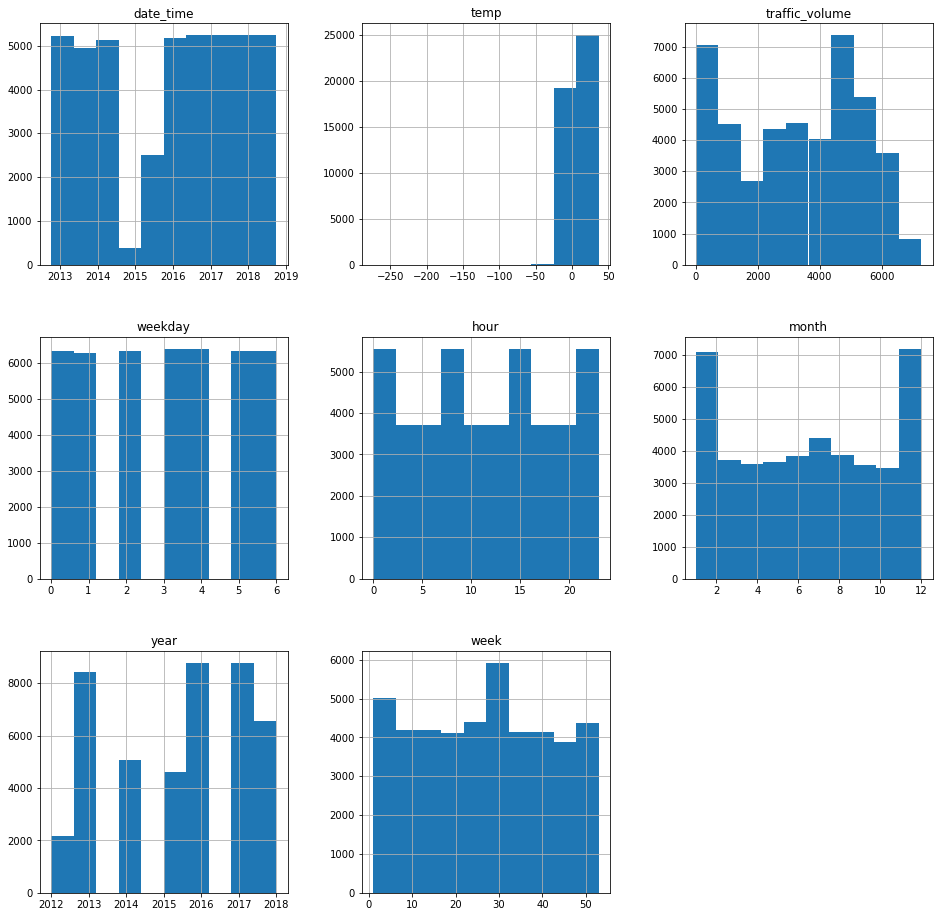

In [100]:
df_interpolated.hist(figsize=(16,16))
plt.show()

Отобразим матрицу коррелции числовых признаков:

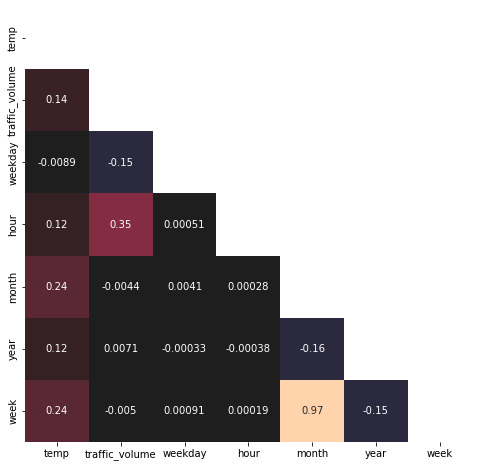

In [101]:
plt.figure(figsize=(8,8))

corr_matrix = df_interpolated.corr()
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool))

sns.heatmap(lower, annot=True, cbar=False, center=0);

Из всех числовых признаков целевая переменная наиболее сильно зависит от часа суток.

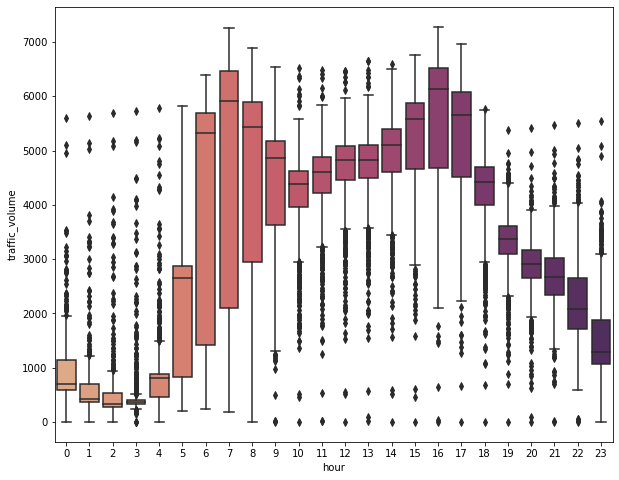

In [102]:
plt.figure(figsize=(10,8))
sns.boxplot(y='traffic_volume',x='hour', data=df_interpolated, palette='flare')
plt.show()

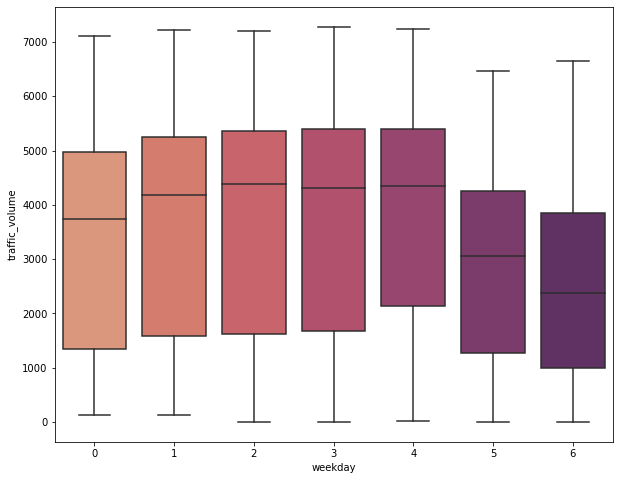

In [103]:
plt.figure(figsize=(10,8))
sns.boxplot(y='traffic_volume',x='weekday', data=df_interpolated, palette='flare')
plt.show()

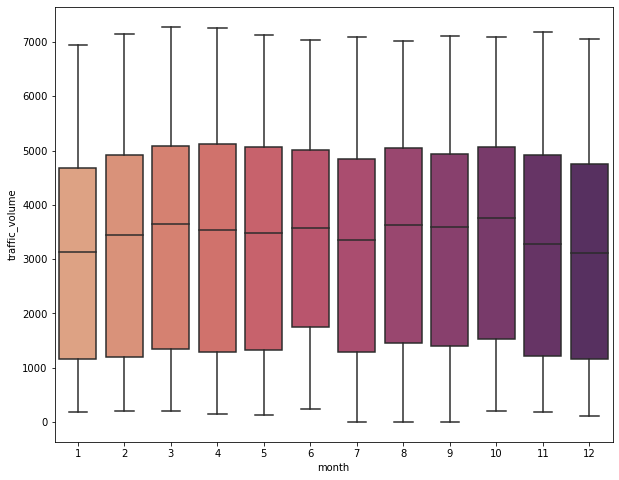

In [104]:
plt.figure(figsize=(10,8))
sns.boxplot(y='traffic_volume',x='month', data=df_interpolated, palette='flare')
plt.show()

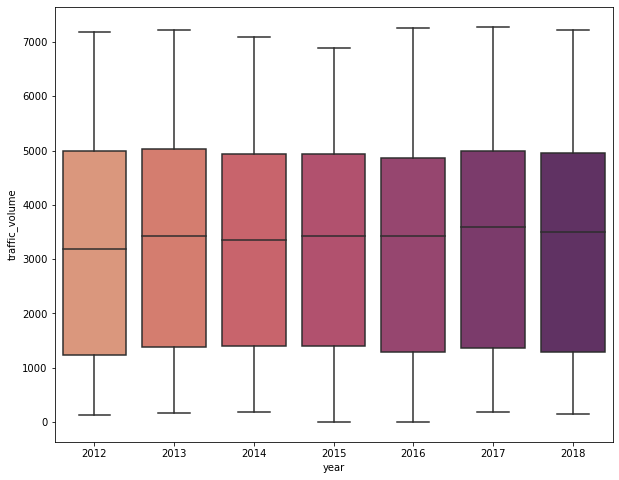

In [105]:
plt.figure(figsize=(10,8))
sns.boxplot(y='traffic_volume',x='year', data=df_interpolated, palette='flare')
plt.show()

Ищем день, предшествующий 14 днями последнему дню датасета:

In [106]:
df_interpolated.iloc[-1:]['date_time'] + timedelta(-13)

44394   2018-09-17 23:00:00
Name: date_time, dtype: datetime64[ns]

Тестовый набор данных будет - 14 дней после 16.09.22, тренировоночный набор - 30 дней перед тестовым, т.е. с 17.08.2018:

In [107]:
border_date = '2018-09-17 00:00:00'
start_date = datetime.strptime('2018-09-17 00:00:00', '%Y-%m-%d %H:%M:%S') + timedelta(-28)

In [108]:
df_train = df_interpolated.loc[(df_interpolated['date_time'] >= start_date.strftime('%Y-%m-%d %H:%M:%S')) & (df_interpolated['date_time'] < border_date)].copy()
df_test = df_interpolated.loc[df_interpolated['date_time'] >= border_date].copy()

In [109]:
df_train

,date_time,holiday,temp,traffic_volume,weekday,hour,month,year,week
43387,2018-08-20 00:00:00,None,23.07,922.0,0,0,8,2018,34
43388,2018-08-20 01:00:00,None,22.47,473.0,0,1,8,2018,34
43389,2018-08-20 02:00:00,None,21.67,346.0,0,2,8,2018,34
43390,2018-08-20 03:00:00,None,21.54,369.0,0,3,8,2018,34
43391,2018-08-20 04:00:00,None,21.34,941.0,0,4,8,2018,34
...,...,...,...,...,...,...,...,...,...
44054,2018-09-16 19:00:00,None,29.87,3400.0,6,19,9,2018,37
44055,2018-09-16 20:00:00,None,27.63,3092.0,6,20,9,2018,37
44056,2018-09-16 21:00:00,None,25.75,2623.0,6,21,9,2018,37
44057,2018-09-16 22:00:00,None,24.70,1725.0,6,22,9,2018,37


In [110]:
df_test

,date_time,holiday,temp,traffic_volume,weekday,hour,month,year,week
44059,2018-09-17 00:00:00,None,23.43,550.0,0,0,9,2018,38
44060,2018-09-17 01:00:00,None,23.04,280.0,0,1,9,2018,38
44061,2018-09-17 02:00:00,None,22.67,260.0,0,2,9,2018,38
44062,2018-09-17 03:00:00,None,22.68,344.0,0,3,9,2018,38
44063,2018-09-17 04:00:00,None,22.53,880.0,0,4,9,2018,38
...,...,...,...,...,...,...,...,...,...
44390,2018-09-30 19:00:00,None,10.30,3543.0,6,19,9,2018,39
44391,2018-09-30 20:00:00,None,9.61,2781.0,6,20,9,2018,39
44392,2018-09-30 21:00:00,None,9.58,2159.0,6,21,9,2018,39
44393,2018-09-30 22:00:00,None,8.94,1450.0,6,22,9,2018,39


In [111]:
# pd.plotting.register_matplotlib_converters()

In [112]:
df_train.index = df_train['date_time']
df_test.index = df_test['date_time']

In [113]:
df_train.index = pd.DatetimeIndex(df_train.index.values, freq=df_train.index.inferred_freq)
df_test.index = pd.DatetimeIndex(df_test.index.values, freq=df_test.index.inferred_freq)

Отобразим графики целевой переменной тренировочного и тестового наборов данных:

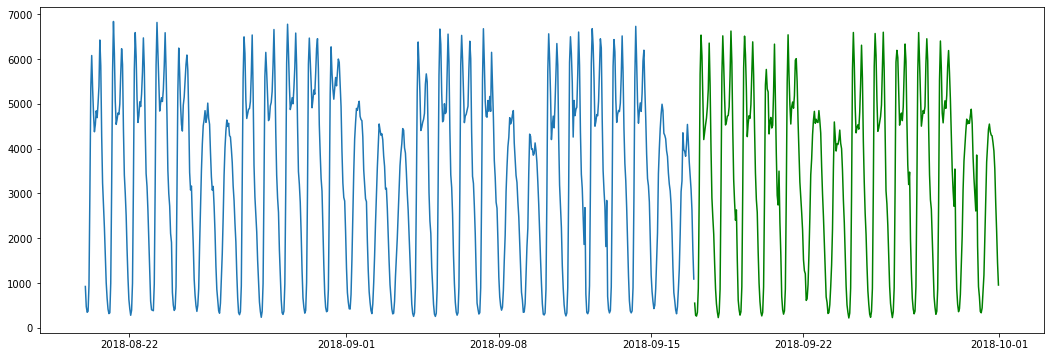

In [114]:
plt.figure(figsize=(18,6))
plt.plot(df_train.traffic_volume)
plt.plot(df_test.traffic_volume, color='green')
plt.show()

Наблюдается ярко выраженная недельная цикличность. Построим базовы прогноз методом скользящего среднего:

In [115]:
moving_average = df_train['traffic_volume'].rolling(window=8).mean()

In [116]:
def plot_two_series(actual_series, predicted_series):
    fig = plt.figure(figsize=(18, 10))
    ax = fig.add_subplot()
    ax.plot(actual_series, label='Оригинальный ряд')
    ax.plot(predicted_series, color='red', label='Предсказанный ряд')
    plt.legend(loc='upper left')
    plt.show()

Красным цветом отобразим график базового прогноза:

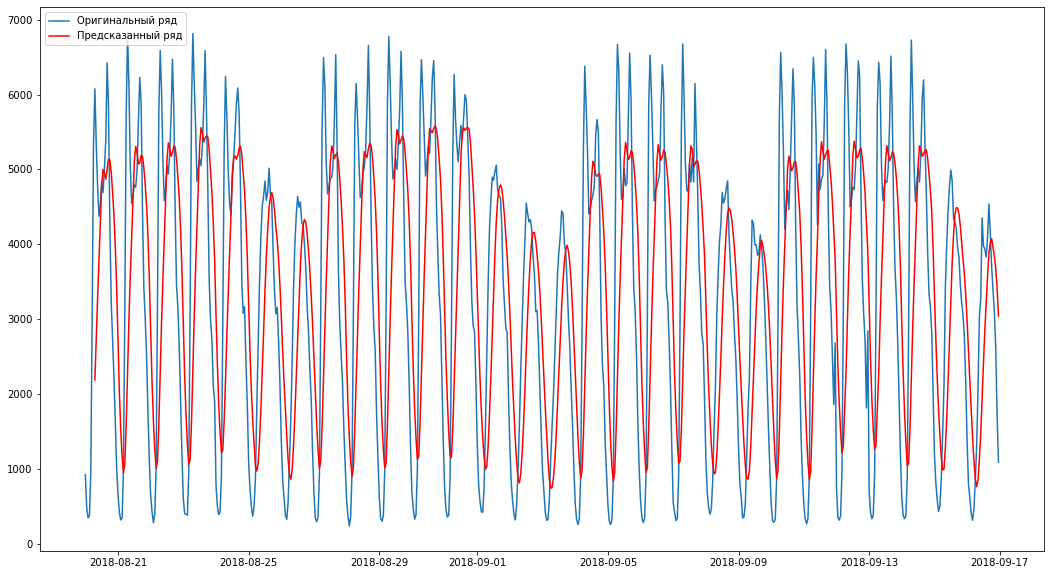

In [117]:
plot_two_series(df_train.traffic_volume, moving_average)

Построим базовый прогноз исходя из данных среднего значения целевой для каждого дня недели и часа суток:

In [118]:
wh_mean = df_train.groupby(['weekday', 'hour'])['traffic_volume'].mean()

In [119]:
df_wh_mean = wh_mean.to_frame()

In [120]:
df_wh_mean = df_wh_mean.reset_index()

In [121]:
df_wh_mean

,weekday,hour,traffic_volume
0,0,0,771.00
1,0,1,451.75
2,0,2,336.25
3,0,3,341.50
4,0,4,765.00
...,...,...,...
163,6,19,3230.25
164,6,20,2950.50
165,6,21,2440.50
166,6,22,1809.50


Отобразим график базового прогноза, он состоит из 168 отсчетов - точка на каждый час недели:

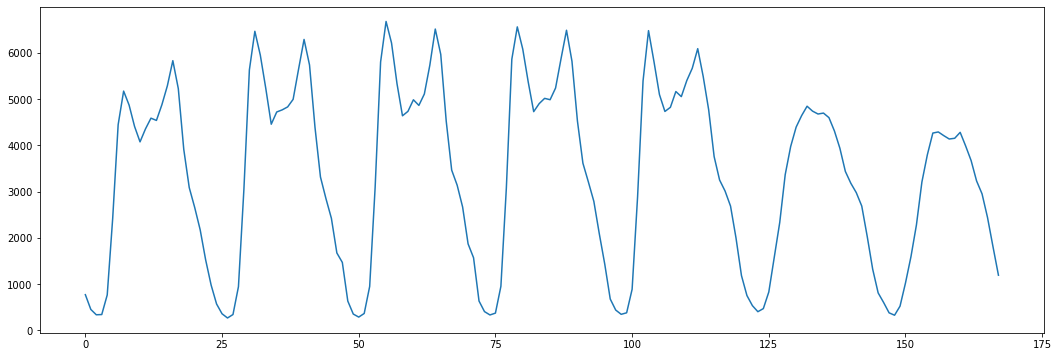

In [122]:
plt.figure(figsize=(18,6))
plt.plot(df_wh_mean.traffic_volume)
plt.show()

Напишем функцию для расчета метрик качества:

In [123]:
def error_metrics(y_test, y_pred):
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    r2 = metrics.r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print(f'Метрики качества:')
    print(f'\tMAE: {mae}')
    print(f'\tMSE: {mse}')
    print(f'\tRMSE: {rmse}')
    print(f'\tR2: {r2}')
    print(f'\tMAPE: {mape}%')

Оценим качество предсказания базового прогноза для наших тестовых данных, для этого создадим датасет объединением тестового датасета и базового прогноза по номеру дня недели и часа суток:

In [124]:
df_test_ma = pd.merge(df_test, df_wh_mean,  how='left', left_on=['weekday','hour'], right_on = ['weekday','hour'])

In [125]:
error_metrics(df_test_ma['traffic_volume_x'], df_test_ma['traffic_volume_y'])

Метрики качества:
	MAE: 204.69717261904762
	MSE: 108608.84495907738
	RMSE: 329.558560743121
	R2: 0.9718081182564514
	MAPE: 8.361013120362063%


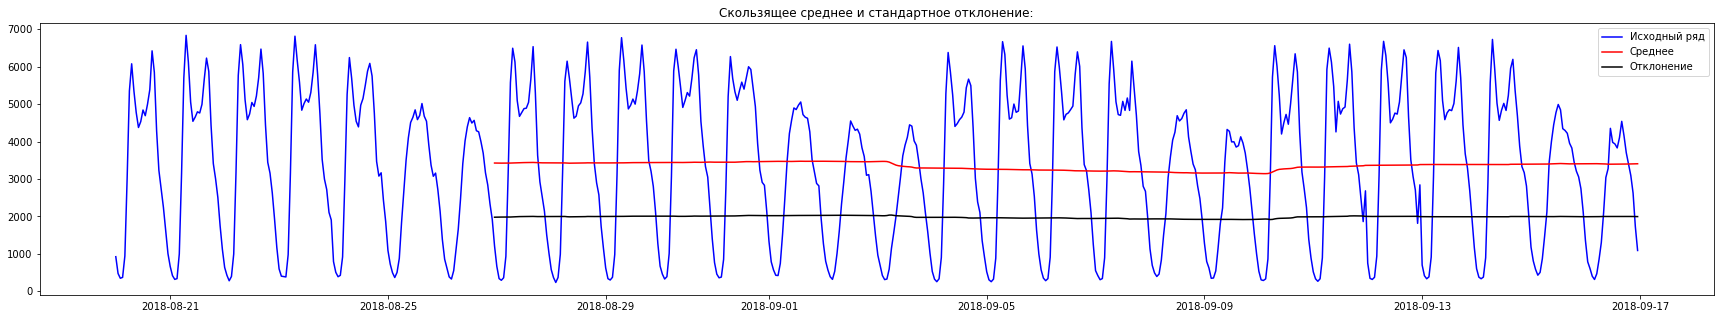

Тест Дикки-Фуллера::
p-value = 0.14574081244238013 анализируемый ряд нестационарный
Статистический тест      -2.385952
p-value                   0.145741
Кол-во лагов             24.000000
Количество точек        647.000000
Critical Value (1%)      -3.440498
Critical Value (5%)      -2.866017
Critical Value (10%)     -2.569154
dtype: float64


In [126]:
window = 24 * 7
cutoff = 0.05
rolmean = df_train.traffic_volume.rolling(window).mean()
rolstd = df_train.traffic_volume.rolling(window).std()

fig = plt.figure(figsize=(30, 5))
orig = plt.plot(df_train.traffic_volume, color='blue',label='Исходный ряд')
mean = plt.plot(rolmean, color='red', label='Среднее')
std = plt.plot(rolstd, color='black', label = 'Отклонение')
plt.legend(loc='best')
plt.title('Скользящее среднее и стандартное отклонение:')
plt.show()

print('Тест Дикки-Фуллера::')
dftest = adfuller(df_train.traffic_volume, autolag='AIC', maxlag = 24 )
dfoutput = pd.Series(dftest[0:4], index=['Статистический тест','p-value','Кол-во лагов','Количество точек'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
pvalue = dftest[1]
if pvalue < cutoff:
    print(f'p-value = {pvalue} анализируемый ряд стационарный')
else:
    print(f'p-value = {pvalue} анализируемый ряд нестационарный')

print(dfoutput)

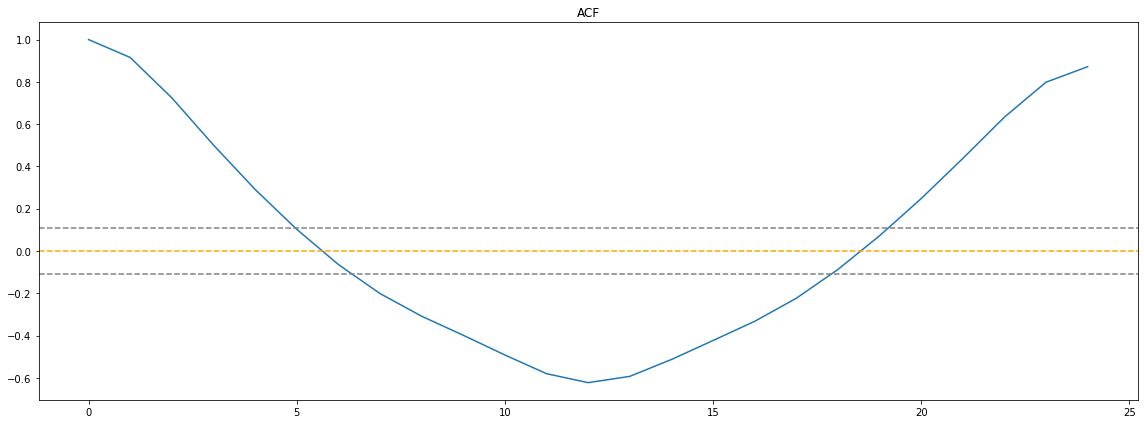

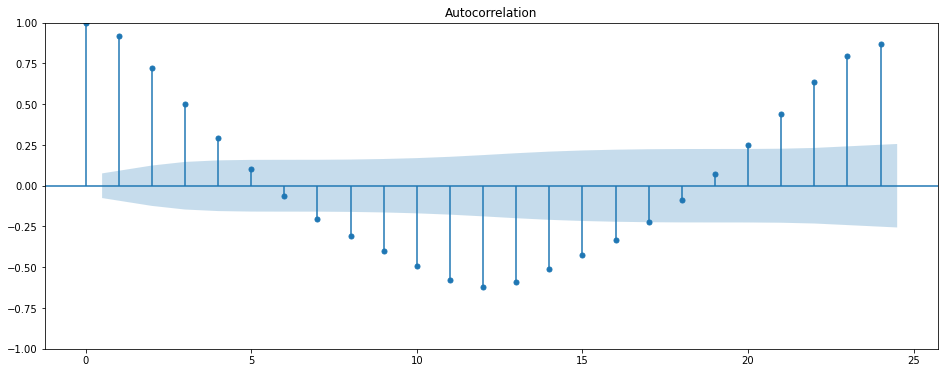

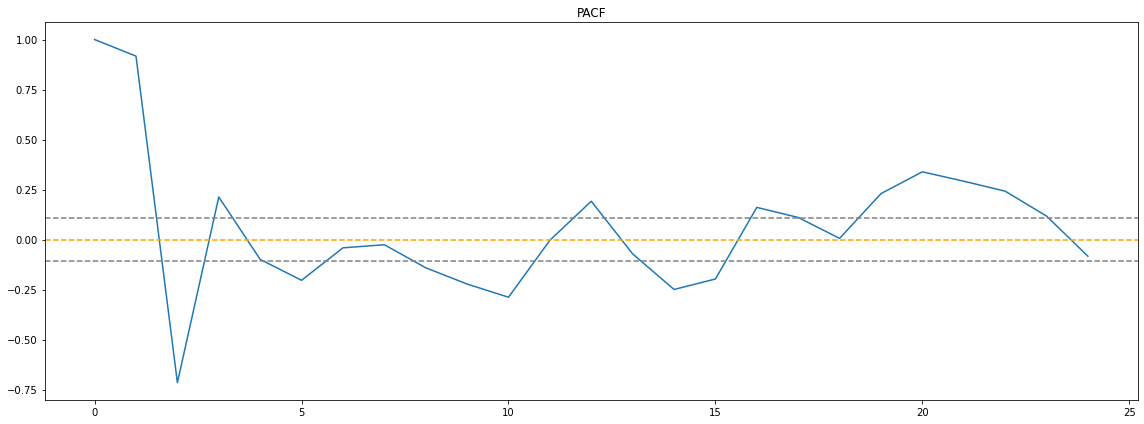

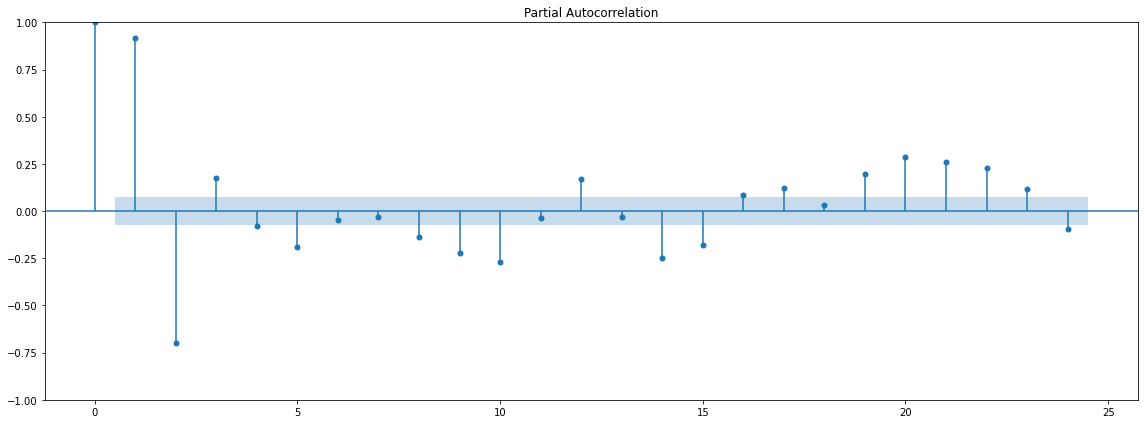

In [127]:
lag = 24
lag_pacf = pacf(df_train.traffic_volume, nlags=lag, method='ols')
lag_acf = acf(df_train.traffic_volume, nlags=lag)
plt.figure(figsize=(16,6))
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='orange')
plt.axhline(y=-1.96/np.sqrt(len(df_test)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_test)),linestyle='--',color='gray')
plt.title('ACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,6))
plot_acf(df_train.traffic_volume, ax=plt.gca(),lags=lag)
plt.show()

plt.figure(figsize=(16,6))
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='orange')
plt.axhline(y=-1.96/np.sqrt(len(df_test)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_test)),linestyle='--',color='gray')
plt.title('PACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,6))
plot_pacf(df_train.traffic_volume, ax=plt.gca(), lags=lag, method='ywm')
plt.tight_layout()
plt.show()

Исходя из графиков, параметры следующие:

In [128]:
p = 2
d = 0
q = 1

Построим модель ARIMA с данными параметрами:

In [129]:
model = sm.tsa.arima.ARIMA(df_train.traffic_volume, order=(p, d, q))  
results_arima = model.fit()

Отобразим прилегание модели:

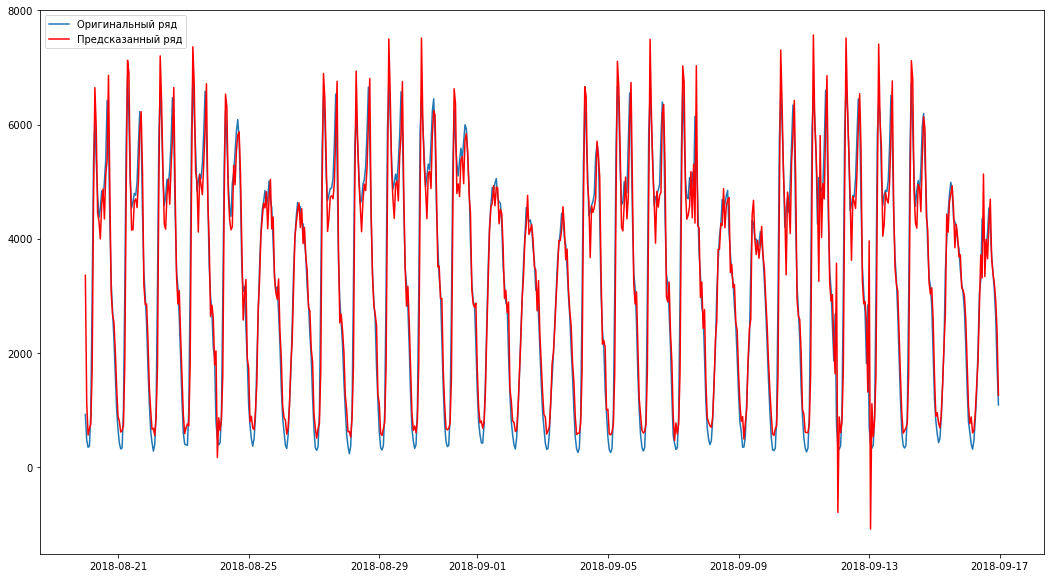

In [130]:
plot_two_series(df_train.traffic_volume, results_arima.fittedvalues)

Предскажем значения для тестового набора с помощью построенной модели:

In [136]:
def arima_forecast(current_value, p, d, q):
    model = sm.tsa.arima.ARIMA(current_value, order=(p, d, q))
    model_fit = model.fit()
    prediction = model_fit.forecast()[0]
    return prediction

In [137]:
values_list = df_test.traffic_volume.to_list()
pred_list = []

for point in range(len(values_list)):
    current_value =  df_test.traffic_volume[point]
    pred = arima_forecast(values_list, p,d,q)    
    pred_list.append(pred)
    values_list.append(current_value)  

arima_pred_df=pd.DataFrame(pred_list).set_index(df_test.index)

In [139]:
error_metrics(df_test.traffic_volume, pred_list)

Метрики качества:
	MAE: 420.3429945222015
	MSE: 339525.79746303166
	RMSE: 582.688422283326
	R2: 0.9118684013758879
	MAPE: 26.39190833998663%


Качество предсказания у модели хуже, чем оценка по усредненным значениям для каждого часа, что связано с тем, что ARIMA модель не учитывает недельную сезонность.

Визуализируем предсказанные значения:

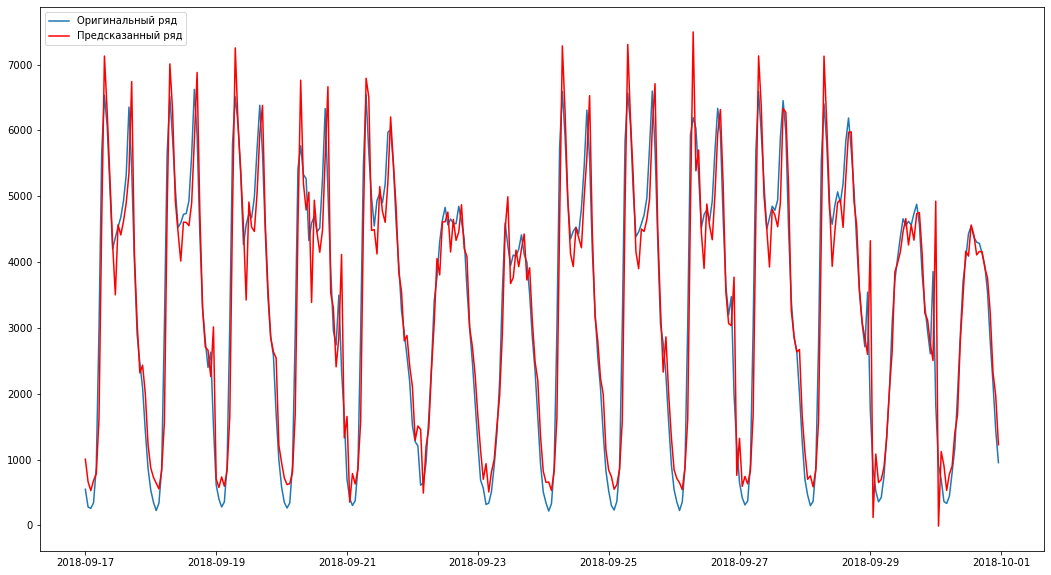

In [140]:
plot_two_series(df_test.traffic_volume, arima_pred_df)

Подберем оптимальные параметры для модели:

In [153]:
model = pm.auto_arima(df_train.traffic_volume, test='adf',
                      start_p=0, start_q=0, 
                      max_p=3, max_q=3, max_P=3, max_Q=3, max_D=3,
                      start_P=0, D=None,
                      m=24 * 7, d=None, seasonal=True, 
                      trace=True, error_action='ignore', suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,1)[168] intercept   : AIC=11545.675, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[168] intercept   : AIC=12111.364, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[168] intercept   : AIC=inf, Time=6.93 sec
 ARIMA(0,0,1)(0,0,1)[168] intercept   : AIC=10862.095, Time=2.14 sec
 ARIMA(0,0,0)(0,0,0)[168]             : AIC=13021.916, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[168] intercept   : AIC=11344.146, Time=0.21 sec
 ARIMA(0,0,1)(1,0,1)[168] intercept   : AIC=10796.386, Time=1.69 sec
 ARIMA(0,0,1)(1,0,0)[168] intercept   : AIC=10558.550, Time=1.52 sec
 ARIMA(0,0,1)(2,0,0)[168] intercept   : AIC=11080.727, Time=9.10 sec
 ARIMA(0,0,1)(2,0,1)[168] intercept   : AIC=inf, Time=16.68 sec
 ARIMA(0,0,0)(1,0,0)[168] intercept   : AIC=inf, Time=3.38 sec
 ARIMA(1,0,1)(1,0,0)[168] intercept   : AIC=9997.091, Time=2.07 sec
 ARIMA(1,0,1)(0,0,0)[168] intercept   : AIC=10515.106, Time=0.39 sec
 ARIMA(1,0,1)(2,0,0)[168] intercept   : AIC=9997.996, Time=7.72 sec
 ARIMA(1,0

Строим модель с выбранными оптимальными параметрами:

In [190]:
model = sm.tsa.statespace.SARIMAX(df_train.traffic_volume, order=(2,0,1), seasonal_order=(1,0,1, 24 * 7))
results = model.fit()

In [142]:
forecast_df = results.forecast(336)

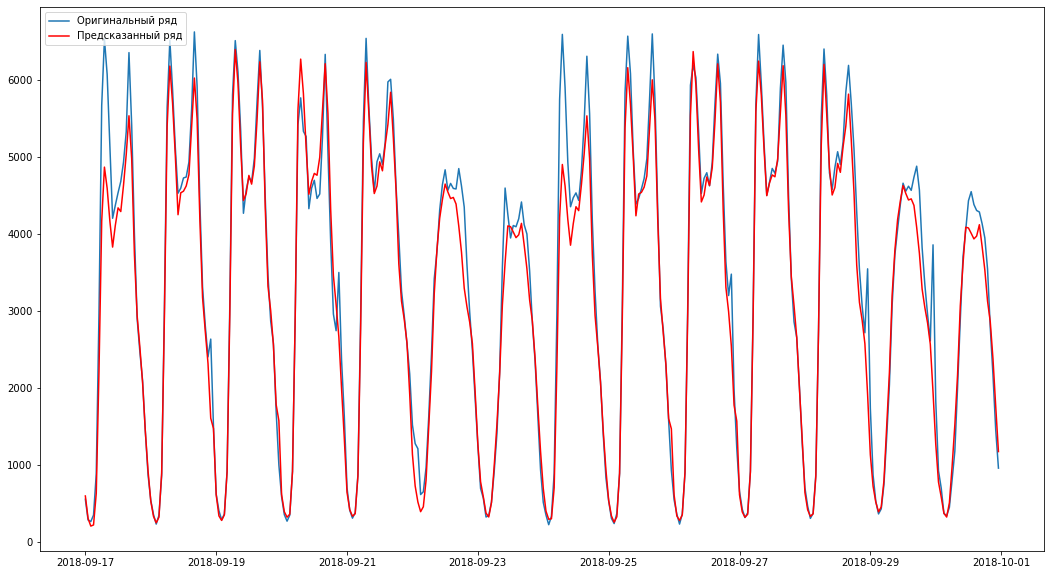

In [143]:
plot_two_series(df_test.traffic_volume, forecast_df)

In [144]:
error_metrics(df_test.traffic_volume, forecast_df)

Метрики качества:
	MAE: 216.59821428571428
	MSE: 125271.56833633915
	RMSE: 353.9372378492254
	R2: 0.9846397247880473
	MAPE: 7.92431754332283%


Проанализируем возможность предсказания с использованием температуры в качестве признака:

In [134]:
var_df_train = df_train[['traffic_volume', 'temp']]
var_df_test = df_test[['traffic_volume', 'temp']]

In [ ]:
plot_two_series(var_df_train.traffic_volume, var_df_train.temp)

In [135]:
var_model = VAR(var_df_train)

In [136]:
order_select = var_model.select_order()
order_select.summary()

,AIC,BIC,FPE,HQIC
0,18.22,18.23,8.144e+07,18.22
1,13.16,13.20,5.206e+05,13.18
2,11.46,11.53,9.466e+04,11.48
3,11.40,11.49,8.898e+04,11.43
4,11.35,11.47,8.485e+04,11.40
5,11.29,11.44,7.979e+04,11.35
6,11.28,11.46,7.944e+04,11.35
7,11.28,11.48,7.910e+04,11.36
8,11.26,11.49,7.771e+04,11.35
9,11.19,11.45,7.268e+04,11.29


In [137]:
results = var_model.fit(19)

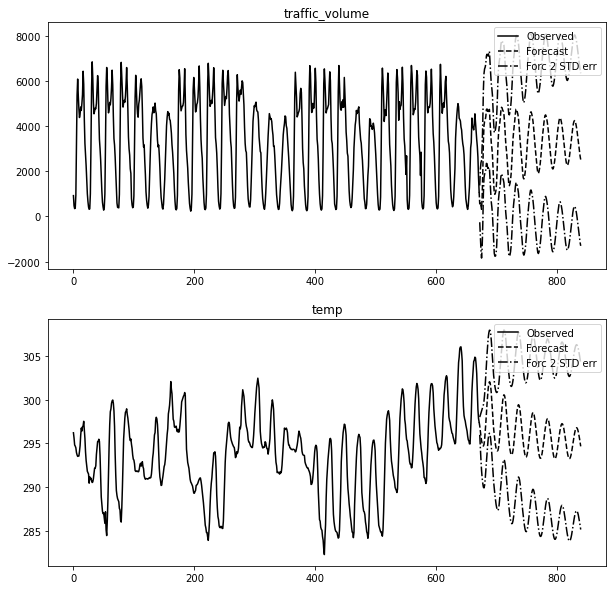

In [141]:
results.plot_forecast(168);

In [ ]:
Даже без подсчета метрик видно, что способность предсказывать у этой модели низкая - вероятнее всего причина в отсутствии волатильности между температурой и траффиком для данного временного ряда

По причине наличия сезонности SARIMA модель будет лучшим вариантом предсказания для данного временного ряда, отобразим предсказание и доверительный интервал для него: 

In [151]:
forecast_week = results.forecast(504)

In [185]:
line = forecast_week.tail(336).rolling(8).mean()
line_deviation = 2 * forecast_week.tail(336).rolling(8).std()
under_line = line - line_deviation
over_line = line + line_deviation

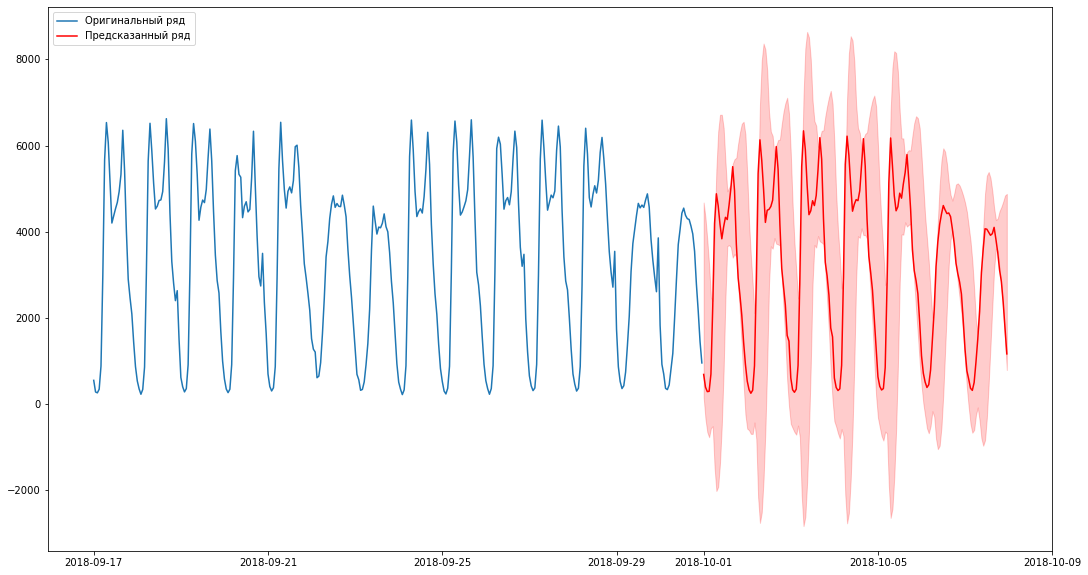

In [191]:
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot()
ax.plot(df_test.traffic_volume, label='Оригинальный ряд')
ax.plot(forecast_week.tail(168), color='red', label='Предсказанный ряд')
ax.fill_between(line_deviation.tail(168).index, under_line.tail(168), over_line.tail(168), color='red', alpha=.2)
plt.legend(loc='upper left')
plt.show()